In [1]:
import sys
sys.path.append('../scr')

import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data.load_data import load_data_from_csv
from trade.trading_strategy import moving_average_strategy
from trade.backtest import simulate_trades_with_allocation
from utils import *


tickers = ['GOOGL', 'AMZN', 'AAPL', 'PEP', 'JNJ', 'PFE', 'MRK', 'ABBV', 'PG', 'KO',
           'WMT', 'JPM', 'BAC', 'GS', 'V', 'XOM', 'CVX', 'COP', 'BP', 'BA',
           'MMM', 'HON', 'GE', 'T', 'VZ', 'TMUS', 'HSY', 'DUK', 'SO', 'EXC', 'AEP',
           'AMT', 'PLD', 'SPG', 'BHP', 'RIO', 'VALE', 'FCX']
start_date = '2010-01-01'
end_date = '2023-10-23'
sequence_length = 50
window_sizes = [50, 40, 30]

Processing GOOGL...


2024-12-23 17:29:12.619594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 17:29:12.620916: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


22/22 [==============================] - 2s 43ms/step
Processing AMZN...
22/22 [==============================] - 1s 42ms/step
Processing AAPL...
22/22 [==============================] - 1s 38ms/step
Processing PEP...
22/22 [==============================] - 1s 39ms/step
Processing JNJ...
22/22 [==============================] - 1s 39ms/step
Processing PFE...
22/22 [==============================] - 1s 38ms/step
Processing MRK...
22/22 [==============================] - 1s 37ms/step
Processing ABBV...
17/17 [==============================] - 1s 39ms/step
Processing PG...
22/22 [==============================] - 2s 43ms/step
Processing KO...
22/22 [==============================] - 1s 36ms/step
Processing WMT...
22/22 [==============================] - 1s 37ms/step
Processing JPM...
22/22 [==============================] - 1s 38ms/step
Processing BAC...
22/22 [==============================] - 1s 36ms/step
Processing GS...
22/22 [==============================] - 1s 39ms/step
Processing

In [8]:
predictions, actuals = get_predictions(tickers, start_date, end_date, sequence_length, folder_path='models')

trading_signals = moving_average_strategy(predictions)

portfolio_returns = simulate_trades_with_allocation(predictions, actuals, trading_signals, initial_capital=100000, allocation_percentage=0.1, slippage_rate=0.02, transaction_cost=0.005)



Processing GOOGL...
22/22 [==============================] - 1s 42ms/step
Processing AMZN...
22/22 [==============================] - 1s 37ms/step
Processing AAPL...
22/22 [==============================] - 1s 41ms/step
Processing PEP...
22/22 [==============================] - 1s 38ms/step
Processing JNJ...
22/22 [==============================] - 1s 39ms/step
Processing PFE...
22/22 [==============================] - 1s 39ms/step
Processing MRK...
22/22 [==============================] - 2s 38ms/step
Processing ABBV...
17/17 [==============================] - 1s 44ms/step
Processing PG...
22/22 [==============================] - 1s 40ms/step
Processing KO...
22/22 [==============================] - 2s 46ms/step
Processing WMT...
22/22 [==============================] - 1s 39ms/step
Processing JPM...
22/22 [==============================] - 1s 42ms/step
Processing BAC...
22/22 [==============================] - 1s 39ms/step
Processing GS...
22/22 [==============================] - 1s 

In [4]:
plot_and_save_attack_model('GOOGL', start_date, end_date, sequence_length, 90, 'models/GOOGL_model.h5', 'plots')


22/22 [==============================] - 1s 46ms/step


In [5]:
# We attack only GOOGL on day 90, but we give all tickers as parameters to simulate portfolio backtest of all tickers, including the attacked prediction.

plot_cumulative_returns_after_attack_day(tickers, start_date, end_date, sequence_length, window_sizes, 90)


Processing GOOGL...
22/22 [==============================] - 1s 43ms/step
Processing AMZN...
22/22 [==============================] - 2s 40ms/step
Processing AAPL...
22/22 [==============================] - 1s 40ms/step
Processing PEP...
22/22 [==============================] - 2s 44ms/step
Processing JNJ...
22/22 [==============================] - 1s 40ms/step
Processing PFE...
22/22 [==============================] - 1s 34ms/step
Processing MRK...
22/22 [==============================] - 1s 39ms/step
Processing ABBV...
17/17 [==============================] - 1s 40ms/step
Processing PG...
22/22 [==============================] - 1s 37ms/step
Processing KO...
22/22 [==============================] - 1s 40ms/step
Processing WMT...
22/22 [==============================] - 1s 43ms/step
Processing JPM...
22/22 [==============================] - 1s 38ms/step
Processing BAC...
22/22 [==============================] - 1s 38ms/step
Processing GS...
22/22 [==============================] - 1s 

In [7]:
def compare_sharpe_ratios_all_days(tickers, start_date, end_date, sequence_length, window_sizes, file_path):
    # Initialize counters for each window size
    lower_count = {window_size: 0 for window_size in window_sizes}
    higher_count = {window_size: 0 for window_size in window_sizes}
    same_count = {window_size: 0 for window_size in window_sizes}

    predictions, actuals = get_predictions(tickers, start_date, end_date, sequence_length)
    trading_signals = moving_average_strategy(predictions)
    portfolio_returns_before = simulate_trades_with_allocation(predictions, actuals, trading_signals)
    sharpe_before = daily_sharpe_ratio(portfolio_returns_before)

    total_days = len(portfolio_returns_before)  

    for attack_day in range(total_days):
        for window_size in window_sizes:
            attacked_predictions, _, _ = perform_ephemeral_attack('GOOGL', start_date, end_date, sequence_length, attack_day, window_size=window_size)
            predictions['GOOGL'] = attacked_predictions['GOOGL']
            
            trading_signals = moving_average_strategy(predictions)
            portfolio_returns_after = simulate_trades_with_allocation(predictions, actuals, trading_signals)
            sharpe_after = daily_sharpe_ratio(portfolio_returns_after)

            if sharpe_after < sharpe_before:
                lower_count[window_size] += 1
            elif sharpe_after > sharpe_before:
                higher_count[window_size] += 1
            else:
                same_count[window_size] += 1

    results_dir = os.path.dirname(file_path)
    os.makedirs(results_dir, exist_ok=True)

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Window Size', 'Lower Sharpe Ratio', 'Higher Sharpe Ratio', 'Same Sharpe Ratio'])
        for window_size in window_sizes:
            writer.writerow([window_size, lower_count[window_size], higher_count[window_size], same_count[window_size]])

    return lower_count, higher_count, same_count


file_path = 'results/sharpe_ratio_results.csv'

lower_count, higher_count, same_count = compare_sharpe_ratios_all_days(tickers, start_date, end_date, sequence_length, window_sizes, file_path)

print(f"Results saved to {file_path}")

Processing GOOGL...
22/22 [==============================] - 1s 38ms/step
Processing AMZN...
22/22 [==============================] - 1s 44ms/step
Processing AAPL...
22/22 [==============================] - 1s 38ms/step
Processing PEP...
22/22 [==============================] - 1s 41ms/step
Processing JNJ...
22/22 [==============================] - 1s 37ms/step
Processing PFE...
22/22 [==============================] - 2s 48ms/step
Processing MRK...
22/22 [==============================] - 2s 61ms/step
Processing ABBV...
17/17 [==============================] - 1s 36ms/step
Processing PG...
22/22 [==============================] - 1s 40ms/step
Processing KO...
22/22 [==============================] - 1s 42ms/step
Processing WMT...
22/22 [==============================] - 2s 39ms/step
Processing JPM...
22/22 [==============================] - 2s 44ms/step
Processing BAC...
22/22 [==============================] - 1s 41ms/step
Processing GS...
22/22 [==============================] - 1s 

In [14]:
import os
import csv
import copy
import pandas as pd  # Optional: For easier data handling and visualization

def compare_sharpe_ratios_all_days(tickers, start_date, end_date, sequence_length, window_sizes, file_path):
    """
    Compares Sharpe ratios before and after attacks on a specified ticker across all days and window sizes.
    Saves the actual Sharpe ratios to a CSV file for further analysis and visualization.

    Parameters:
    - tickers (list): List of ticker symbols.
    - start_date (str): Start date for the simulation (e.g., '2020-01-01').
    - end_date (str): End date for the simulation (e.g., '2021-01-01').
    - sequence_length (int): Sequence length parameter for predictions.
    - window_sizes (list): List of window sizes for attacks.
    - file_path (str): Path to save the resulting CSV file.

    Returns:
    - None
    """
    # Initialize a list to store results
    results = []

    # Load baseline predictions and actuals
    predictions_baseline, actuals = get_predictions(tickers, start_date, end_date, sequence_length, folder_path='models')

    # Generate baseline trading signals and portfolio returns
    trading_signals_baseline = moving_average_strategy(predictions_baseline)
    portfolio_returns_before = simulate_trades_with_allocation(
        predictions_baseline, actuals, trading_signals_baseline,
        initial_capital=100000, allocation_percentage=0.1,
        slippage_rate=0.02, transaction_cost=0.005
    )

    # Calculate baseline Sharpe ratio
    sharpe_before = daily_sharpe_ratio(portfolio_returns_before)

    # Total number of days
    total_days = len(portfolio_returns_before)

    print(f"Baseline Sharpe Ratio: {sharpe_before}")

    # Iterate over each attack day and window size
    for attack_day in range(total_days):
        for window_size in window_sizes:
            # Create a deep copy of baseline predictions to avoid in-place modifications
            predictions_attacked = copy.deepcopy(predictions_baseline)

            # Perform attack on the specified ticker ('GOOGL')
            attacked_predictions, _, _ = perform_ephemeral_attack(
                'GOOGL', start_date, end_date, sequence_length,
                attack_day, window_size=window_size
            )

            # Update the predictions for the attacked ticker
            predictions_attacked['GOOGL'] = attacked_predictions['GOOGL']

            # Generate trading signals and simulate trades after attack
            trading_signals_attacked = moving_average_strategy(predictions_attacked)
            portfolio_returns_after = simulate_trades_with_allocation(
                predictions_attacked, actuals, trading_signals_attacked,
                initial_capital=100000, allocation_percentage=0.1,
                slippage_rate=0.02, transaction_cost=0.005
            )

            # Calculate Sharpe ratio after attack
            sharpe_after = daily_sharpe_ratio(portfolio_returns_after)

            # Append the result to the list
            results.append({
                'Attack_Day': attack_day,
                'Window_Size': window_size,
                'Sharpe_Before_Attack': sharpe_before,
                'Sharpe_After_Attack': sharpe_after
            })

            # Optional: Print progress every 1000 iterations
            if (attack_day * len(window_sizes) + window_size) % 1000 == 0:
                print(f"Processed Attack Day: {attack_day}, Window Size: {window_size}")

    # Convert results to a DataFrame for easier handling
    results_df = pd.DataFrame(results)

    # Ensure the results directory exists
    results_dir = os.path.dirname(file_path)
    if results_dir:
        os.makedirs(results_dir, exist_ok=True)

    # Save the DataFrame to a CSV file
    results_df.to_csv(file_path, index=False)

    print(f"Sharpe ratio results saved to {file_path}")

# Example usage
file_path = 'results/sharpe_ratio_results_all_days.csv'

compare_sharpe_ratios_all_days(tickers, start_date, end_date, sequence_length, window_sizes, file_path)


Processing GOOGL...
22/22 [==============================] - 1s 38ms/step
Processing AMZN...
22/22 [==============================] - 1s 39ms/step
Processing AAPL...
22/22 [==============================] - 2s 49ms/step
Processing PEP...
22/22 [==============================] - 1s 39ms/step
Processing JNJ...
22/22 [==============================] - 1s 39ms/step
Processing PFE...
22/22 [==============================] - 1s 42ms/step
Processing MRK...
22/22 [==============================] - 1s 39ms/step
Processing ABBV...
17/17 [==============================] - 1s 39ms/step
Processing PG...
22/22 [==============================] - 2s 37ms/step
Processing KO...
22/22 [==============================] - 1s 40ms/step
Processing WMT...
22/22 [==============================] - 2s 42ms/step
Processing JPM...
22/22 [==============================] - 2s 43ms/step
Processing BAC...
22/22 [==============================] - 1s 42ms/step
Processing GS...
22/22 [==============================] - 1s 

In [17]:
import pandas as pd

df = pd.read_csv("results/sharpe_ratio_results_all_days.csv")
atk_30 = df_30['Sharpe_After_Attack']
atk_40 = df_40['Sharpe_After_Attack']
atk_50 = df_50['Sharpe_After_Attack']
baseline = df['Sharpe_Before_Attack'][0]
print(baseline)
df_50 = df[df['Window_Size']==50]
df_40 = df[df['Window_Size']==40]
df_30 = df[df['Window_Size']==30]

results_relative_30 = list()

for index, value in enumerate(atk_30):
    temp = (value - baseline)
    results_relative_30.append(temp)
    
results_relative_40 = list()

for index, value in enumerate(atk_40):
    temp = (value - baseline)
    results_relative_40.append(temp)
    
    
results_relative_50 = list()

for index, value in enumerate(atk_50):
    temp = (value - baseline)
    results_relative_50.append(temp)

1.3935228798586037


In [18]:
counter = 0
# count when the attacker LOSES
for i in results_relative_30:
    if i > 0:
        counter+=1 

print(counter)
print(counter/len(results_relative_30))

counter = 0
# count when the attacker LOSES
for i in results_relative_40:
    if i > 0:
        counter+=1 

print(counter)
print(counter/len(results_relative_40))

counter = 0
# count when the attacker LOSES
for i in results_relative_50:
    if i > 0:
        counter+=1 

print(counter)
print(counter/len(results_relative_50))

27
0.04054054054054054
16
0.024024024024024024
34
0.05105105105105105


Plot saved to plots/attack_plots/impact_SR.pdf


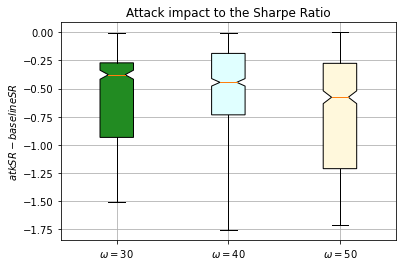

In [19]:
import matplotlib.pyplot as plt
import os

plots_dir = 'plots/attack_plots'
os.makedirs(plots_dir, exist_ok=True)

results = [
    results_relative_30,
    results_relative_40,
    results_relative_50,
]
labels = ['$\omega=30$', '$\omega=40$', '$\omega=50$']
colors = ['ForestGreen', 'LightCyan', 'CornSilk']

fig, ax = plt.subplots()

bplot = ax.boxplot(results,
                   patch_artist=True, 
                   showfliers=False, whis=(5,95), notch=True)  

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(labels)
ax.set_ylabel("$atkSR - baselineSR$")
ax.set_title("Attack impact to the Sharpe Ratio")
    
plt.grid()

plot_path = os.path.join(plots_dir, "impact_SR.pdf")
plt.savefig(plot_path, dpi=300)


print(f"Plot saved to {plot_path}")


In [23]:
import pickle
def compute_new_metric_all_days(tickers, attacked_ticker, start_date, end_date, sequence_length, window_sizes):
    # Load baseline predictions and actuals
    predictions_baseline, actuals = get_predictions(tickers, start_date, end_date, sequence_length, folder_path='models')
    
    # Generate baseline trading signals and portfolio returns
    trading_signals_baseline = moving_average_strategy(predictions_baseline)
    portfolio_returns_baseline = simulate_trades_with_allocation(
        predictions_baseline, actuals, trading_signals_baseline,
        initial_capital=100000, allocation_percentage=0.1,
        slippage_rate=0.02, transaction_cost=0.005
    )
    
    # Cap and compute cumulative returns
    cumulative_returns_baseline = calculate_cumulative_returns(portfolio_returns_baseline)
    
    total_days = len(portfolio_returns_baseline)
    
    # Precompute baseline cumulative returns from each day to the end
    baseline_cumulative_returns = []
    for d in range(total_days):
        if d < total_days - 1:
            cumulative_return = cumulative_returns_baseline[-1] - cumulative_returns_baseline[d]
        else:
            cumulative_return = 0  # Last day
        baseline_cumulative_returns.append(cumulative_return)
    
    # Dictionaries to store NRCRs and the new metric for each window size
    nrcr_after_attacks_all_days = {window_size: [] for window_size in window_sizes}
    new_metric_after_attacks_all_days = {window_size: [] for window_size in window_sizes}
    
    for window_size in window_sizes:
        print(f"Processing window size {window_size}")
        nrcr_list = []
        new_metric_list = []
        
        for attack_day in range(total_days):
            # Copy the baseline predictions to avoid modifying them
            predictions_attacked = {key: predictions_baseline[key].copy() for key in predictions_baseline}
            
            # Perform attack on the specified ticker
            attacked_predictions, _, _ = perform_ephemeral_attack(
                attacked_ticker, start_date, end_date, sequence_length,
                attack_day, window_size=window_size
            )
            # Update the predictions for the attacked ticker
            predictions_attacked[attacked_ticker] = attacked_predictions[attacked_ticker]
            
            # Generate trading signals and simulate trades
            trading_signals_attacked = moving_average_strategy(predictions_attacked)
            portfolio_returns_attacked = simulate_trades_with_allocation(
                predictions_attacked, actuals, trading_signals_attacked,
                initial_capital=100000, allocation_percentage=0.1,
                slippage_rate=0.02, transaction_cost=0.005
            )
            
            # Cap and compute cumulative returns
            cumulative_returns_attacked = calculate_cumulative_returns(portfolio_returns_attacked)
            
            # Compute cumulative return after attack from attack_day to the end
            if attack_day < total_days - 1:
                cumulative_return_attacked = cumulative_returns_attacked[-1] - cumulative_returns_attacked[attack_day]
                cumulative_return_baseline = baseline_cumulative_returns[attack_day]
            else:
                cumulative_return_attacked = 0  # No time left after attack day
                cumulative_return_baseline = 0
                
            # Compute NRCR (normalized by the cumulative return)
            if cumulative_return_baseline != 0:
                nrcr = cumulative_return_attacked / cumulative_return_baseline
            else:
                nrcr = 0  # Handle division by zero
            nrcr_list.append(nrcr)
            
            # Compute the new metric: (Cd - Cb) / (666 - d)
            difference = cumulative_return_attacked - cumulative_return_baseline
            days_remaining = 666 - attack_day
            if days_remaining > 0:
                new_metric = difference / days_remaining
            else:
                new_metric = 0 
            new_metric_list.append(new_metric)
        
        # Store NRCRs and new metric for the current window size
        nrcr_after_attacks_all_days[window_size] = nrcr_list
        new_metric_after_attacks_all_days[window_size] = new_metric_list
    
    # Save the results for plotting
    with open('results/attack_results_new_metric.pkl', 'wb') as f:
        pickle.dump((baseline_cumulative_returns, nrcr_after_attacks_all_days, new_metric_after_attacks_all_days), f)
    
    return baseline_cumulative_returns, nrcr_after_attacks_all_days, new_metric_after_attacks_all_days


In [25]:
baseline_cumulative_returns, nrcr_after_attacks_all_days, new_metric_after_attacks_all_days = compute_new_metric_all_days(
    tickers, 'GOOGL', start_date, end_date, sequence_length, window_sizes)

Processing GOOGL...
22/22 [==============================] - 2s 41ms/step
Processing AMZN...
22/22 [==============================] - 2s 43ms/step
Processing AAPL...
22/22 [==============================] - 1s 36ms/step
Processing PEP...
22/22 [==============================] - 1s 45ms/step
Processing JNJ...
22/22 [==============================] - 2s 46ms/step
Processing PFE...
22/22 [==============================] - 2s 44ms/step
Processing MRK...
22/22 [==============================] - 2s 41ms/step
Processing ABBV...
17/17 [==============================] - 1s 39ms/step
Processing PG...
22/22 [==============================] - 2s 45ms/step
Processing KO...
22/22 [==============================] - 2s 44ms/step
Processing WMT...
22/22 [==============================] - 2s 46ms/step
Processing JPM...
22/22 [==============================] - 2s 42ms/step
Processing BAC...
22/22 [==============================] - 2s 61ms/step
Processing GS...
22/22 [==============================] - 2s 

In [26]:
import pickle
import pandas as pd


with open('results/attack_results_new_metric.pkl', 'rb') as f:
    baseline_cumulative_returns, nrcr_after_attacks_all_days, new_metric_after_attacks_all_days = pickle.load(f)


total_days = len(baseline_cumulative_returns)


baseline_cumulative_return = baseline_cumulative_returns[0]
print("Baseline Cumulative Return (No Attack):", baseline_cumulative_return)

omega_values = [30, 40, 50]  


cr_lists = {}


for omega in omega_values:
    nrcr_list = nrcr_after_attacks_all_days[omega]  
    cr_list = []
    for attack_day in range(total_days):
        

        
        cumulative_return_baseline = baseline_cumulative_returns[attack_day]
        cumulative_return_attacked = nrcr_list[attack_day] * cumulative_return_baseline

        
        if attack_day > 0:
            cumulative_return_before_attack = baseline_cumulative_returns[0] - baseline_cumulative_returns[attack_day]
        else:
            cumulative_return_before_attack = 0  

        total_cumulative_return_attacked = cumulative_return_before_attack + cumulative_return_attacked

        cr_list.append(total_cumulative_return_attacked)
    cr_lists[omega] = cr_list

cr_list_omega_30 = cr_lists[30]
cr_list_omega_40 = cr_lists[40]
cr_list_omega_50 = cr_lists[50]

print(f"Length of CR list for omega=30: {len(cr_list_omega_30)}")
print(f"Length of CR list for omega=40: {len(cr_list_omega_40)}")
print(f"Length of CR list for omega=50: {len(cr_list_omega_50)}")

data = {
    'Attack_Day': range(total_days),
    'Baseline_CR': [baseline_cumulative_return] * total_days,
    'CR_Omega_30': cr_list_omega_30,
    'CR_Omega_40': cr_list_omega_40,
    'CR_Omega_50': cr_list_omega_50
}

df = pd.DataFrame(data)

df.to_csv('results/cumulative_returns.csv', index=False)



Baseline Cumulative Return (No Attack): 23.70794562747103
Length of CR list for omega=30: 666
Length of CR list for omega=40: 666
Length of CR list for omega=50: 666


In [27]:

df = pd.read_csv('results/cumulative_returns.csv')

In [28]:
atk_30 = df['CR_Omega_30']
atk_40 = df['CR_Omega_40']
atk_50 = df['CR_Omega_50']
baseline = df['Baseline_CR'][0]


In [29]:
results_30 = list()

for index, value in enumerate(atk_30):
    temp = (value - baseline) / (666-index)
    results_30.append(temp)
    
results_40 = list()

for index, value in enumerate(atk_40):
    temp = (value - baseline) / (666-index)
    results_40.append(temp)
    
results_50 = list()

for index, value in enumerate(atk_50):
    temp = (value - baseline) / (666-index)
    results_50.append(temp)

In [30]:
results_relative_30 = list()

for index, value in enumerate(atk_30):
    temp = (value / baseline)
    results_relative_30.append(temp)
    
results_relative_40 = list()

for index, value in enumerate(atk_40):
    temp = (value / baseline)
    results_relative_40.append(temp)
    
    
results_relative_50 = list()

for index, value in enumerate(atk_50):
    temp = (value / baseline)
    results_relative_50.append(temp)

In [31]:
counter = 0
# count when the attacker LOSES
for i in results_30:
    if i > 0:
        counter+=1 

print(counter)
print(counter/666)

counter = 0
# count when the attacker LOSES
for i in results_40:
    if i > 0:
        counter+=1 

print(counter)
print(counter/666)

counter = 0
# count when the attacker LOSES
for i in results_50:
    if i > 0:
        counter+=1 



239
0.3588588588588589
260
0.39039039039039036


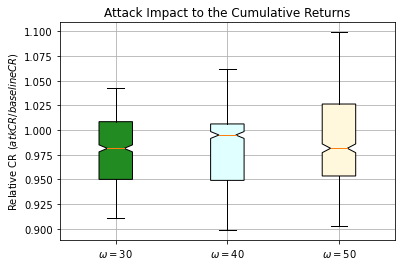

In [32]:
import matplotlib.pyplot as plt



results = [
    results_relative_30,
    results_relative_40,
    results_relative_50,
]
labels = ['$\omega=30$', '$\omega=40$', '$\omega=50$']
colors = ['ForestGreen', 'LightCyan', 'CornSilk']

fig, ax = plt.subplots()


bplot = ax.boxplot(results,
                   patch_artist=True,  
                   showfliers=False, whis=(5,95), notch=True)  


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(labels)
ax.set_title("Attack Impact to the Cumulative Returns")
ax.set_xticklabels(labels)
ax.set_ylabel("Relative CR ($atkCR / baselineCR$)")
    
plt.grid()
plt.savefig("plots/attack_plots/impact_CR-relative.jpeg", dpi=300)
plt.show()

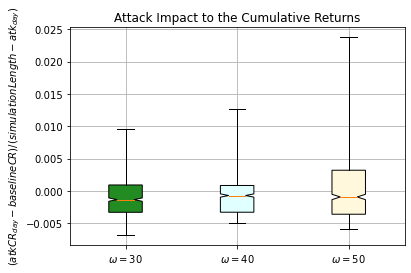

In [33]:
import matplotlib.pyplot as plt



results = [
    results_30,
    results_40,
    results_50,
]
labels = ['$\omega=30$', '$\omega=40$', '$\omega=50$']
colors = ['ForestGreen', 'LightCyan', 'CornSilk']

fig, ax = plt.subplots()


bplot = ax.boxplot(results,
                   patch_artist=True,  # fill with color
                   showfliers=False, whis=(5,95), notch=True)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)




ax.set_xticklabels(labels)
ax.set_title("Attack Impact to the Cumulative Returns")
ax.set_xticklabels(labels)
ax.set_ylabel("$(atkCR_{day} - baselineCR)/(simulationLength - atk_{day})$")
    
plt.grid()
plt.savefig("plots/attack_plots/impact_CR-dailyNormalized.jpeg", dpi=300)
plt.show()

In [3]:
plot_and_save_attack_model('GOOGL', start_date, end_date, sequence_length, 551, 'models/GOOGL_model.h5', 'plots')


22/22 [==============================] - 1s 42ms/step


In [2]:
df = pd.read_csv("results/sharpe_ratio_results_all_days.csv")


In [3]:
df_50 = df[df['Window_Size']==50]
df_40 = df[df['Window_Size']==40]
df_30 = df[df['Window_Size']==30]

In [4]:
atk_30 = df_30['Sharpe_After_Attack']
atk_40 = df_40['Sharpe_After_Attack']
atk_50 = df_50['Sharpe_After_Attack']
baseline = df['Sharpe_Before_Attack'][0]
print(baseline)

1.3935228798586037


In [5]:
results_relative_30 = list()

for index, value in enumerate(atk_30):
    temp = (value - baseline)
    results_relative_30.append(temp)
    
results_relative_40 = list()

for index, value in enumerate(atk_40):
    temp = (value - baseline)
    results_relative_40.append(temp)
    
    
results_relative_50 = list()

for index, value in enumerate(atk_50):
    temp = (value - baseline)
    results_relative_50.append(temp)

In [6]:
counter = 0
# count when the attacker LOSES
for i in results_relative_30:
    if i > 0:
        counter+=1 

print(counter)
print(counter/len(results_relative_30))

counter = 0
# count when the attacker LOSES
for i in results_relative_40:
    if i > 0:
        counter+=1 

print(counter)
print(counter/len(results_relative_40))

counter = 0
# count when the attacker LOSES
for i in results_relative_50:
    if i > 0:
        counter+=1 

print(counter)
print(counter/len(results_relative_50))

27
0.04054054054054054
16
0.024024024024024024
34
0.05105105105105105


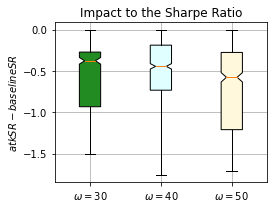

In [7]:
import matplotlib.pyplot as plt



results = [
    results_relative_30,
    results_relative_40,
    results_relative_50,
]
labels = ['$\omega=30$', '$\omega=40$', '$\omega=50$']
colors = ['ForestGreen', 'LightCyan', 'CornSilk']

fig, ax = plt.subplots()

fig.set_figwidth(4)
fig.set_figheight(3)

bplot = ax.boxplot(results,
                   patch_artist=True,  # fill with color
                   showfliers=False, whis=(5,95), notch=True)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(labels)
ax.set_ylabel("$atkSR - baselineSR$")
ax.set_title("Impact to the Sharpe Ratio")
    
plt.grid()
plt.tight_layout()
plt.savefig("plots/attack_plots/impact_SR_MAC.pdf", dpi=300)
plt.show()
